# Imports The Required Libraries

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load GRIB File & Convert It To CSV File

In [3]:
# Load the GRIB file and filter by edition
file_path = "data.grib"
ds = xr.open_dataset(
    file_path,
    engine="cfgrib",
    backend_kwargs={
        "filter_by_keys": {"edition": 1}
    }
)

# Convert to DataFrame
df = ds.to_dataframe().reset_index()

# Save to CSV
csv_file = "extracted_data.csv"
df.to_csv(csv_file, index=False)

skipping variable: paramId==139 shortName='stl1'
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\cfgrib\dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1725148800, 1725235200, 1725321600, 1725408000, 1725494400,
       1725580800, 1725667200, 1725753600, 1725840000, 1725926400,
       1726012800, 1726099200, 1726185600, 1726272000, 1726358400,
       1726444800, 1726531200, 1726617600, 1726704000, 1726790400])) new_value=Variable(dimensions=('time',), data=array([1725192000, 1725195600, 1725199200, 1725202800, 1725206400,
       1725210000, 1725213600, 1725217200, 1725220800, 1725224400,
       172

Data saved to extracted_data.csv


# Load Dataset

In [5]:
data = pd.read_csv('extracted_data.csv')
data.head()

,time,step,latitude,longitude,number,surface,valid_time,t2m,sro,tp
0,2024-09-01,0 days 12:00:00,36.772,50.435000,0,0.0,2024-09-01 12:00:00,293.65430,0.000005,0.000053
1,2024-09-01,0 days 12:00:00,36.772,50.535028,0,0.0,2024-09-01 12:00:00,293.83447,0.000008,0.000095
2,2024-09-01,0 days 12:00:00,36.772,50.635056,0,0.0,2024-09-01 12:00:00,295.16553,0.000007,0.000097
3,2024-09-01,0 days 12:00:00,36.772,50.735083,0,0.0,2024-09-01 12:00:00,296.66700,0.000005,0.000106
4,2024-09-01,0 days 12:00:00,36.772,50.835111,0,0.0,2024-09-01 12:00:00,297.82860,0.000003,0.000107


In [7]:
data.shape

(35520, 10)

In [6]:
data.describe()

,latitude,longitude,number,surface,t2m,sro,tp
count,35520.000000,35520.000000,35520.0,35520.0,35520.000000,3.552000e+04,35520.000000
mean,36.621750,52.235500,0.0,0.0,294.687889,1.010741e-04,0.001676
std,0.112141,1.068019,0.0,0.0,4.891162,3.101852e-04,0.002794
min,36.471000,50.435000,0.0,0.0,278.924070,0.000000e+00,0.000000
25%,36.546750,51.335250,0.0,0.0,291.614260,2.793968e-08,0.000028
50%,36.622000,52.235500,0.0,0.0,295.225095,1.768320e-06,0.000383
75%,36.697000,53.135750,0.0,0.0,298.158940,3.034290e-05,0.002105
max,36.772000,54.036000,0.0,0.0,307.494140,3.882430e-03,0.026095


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35520 entries, 0 to 35519
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        35520 non-null  object 
 1   step        35520 non-null  object 
 2   latitude    35520 non-null  float64
 3   longitude   35520 non-null  float64
 4   number      35520 non-null  int64  
 5   surface     35520 non-null  float64
 6   valid_time  35520 non-null  object 
 7   t2m         35520 non-null  float64
 8   sro         35520 non-null  float64
 9   tp          35520 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.7+ MB


# EDA & Data Preprocessing

In [13]:
# Select relevant features
features = data[['tp', 't2m']]

# Check for missing values (if any)
features.isnull().sum()

tp     0
t2m    0
dtype: int64

Text(0.5, 1.0, 'Distribution of Total Precipitation (tp)')

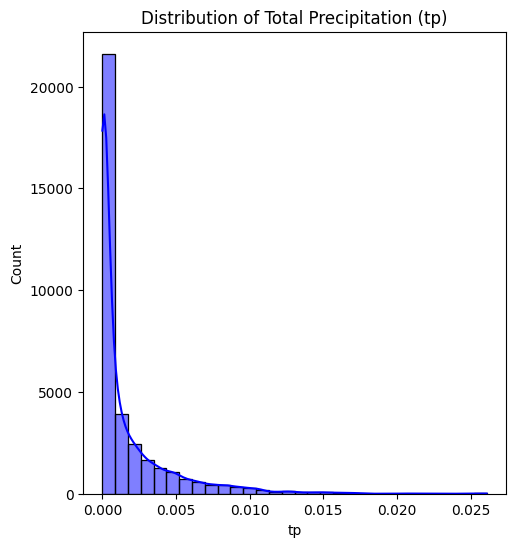

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(features['tp'], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Precipitation (tp)')

Text(0.5, 1.0, 'Distribution of Temperature (t2m)')

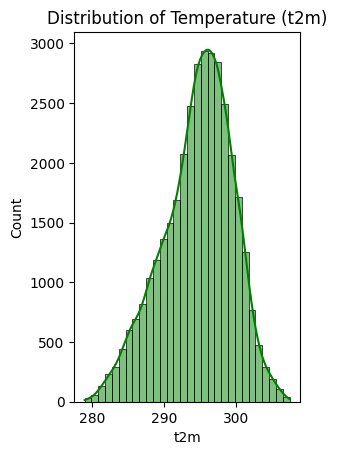

In [16]:
plt.subplot(1, 2, 2)
sns.histplot(features['t2m'], kde=True, bins=30, color='green')
plt.title('Distribution of Temperature (t2m)')

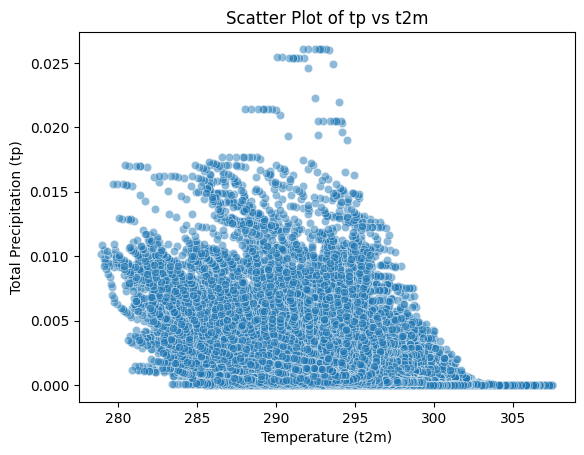

In [18]:
sns.scatterplot(x='t2m', y='tp', data=features, alpha=0.5)
plt.title('Scatter Plot of tp vs t2m')
plt.xlabel('Temperature (t2m)')
plt.ylabel('Total Precipitation (tp)')
plt.show()

# Feature Engineering & Applying PCA

In [19]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Reduce to 2 components
pca_features = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance by PCA: {explained_variance:.2f}")

Explained Variance by PCA: 1.00


# Clustering

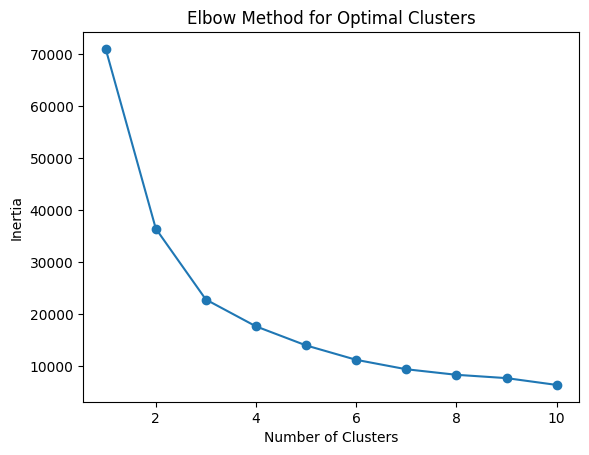

In [20]:
# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [21]:
# Fit KMeans with optimal clusters (e.g., k=3 based on elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)

# Add cluster labels to the original data
data['Cluster'] = clusters